<a href="https://colab.research.google.com/github/kennethkwokop/solar-simulation/blob/main/Tilt_gain_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

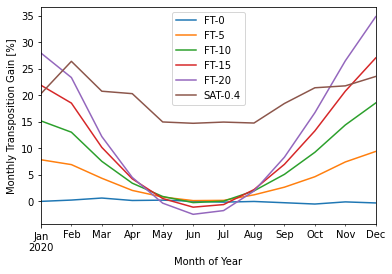

In [ ]:
import pvlib
from pvlib import location
from pvlib import irradiance
from pvlib import tracking
from pvlib.iotools import read_tmy3
import pandas as pd
from matplotlib import pyplot as plt
import pathlib

# get full path to the data directory
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'

# get TMY3 dataset
tmy, metadata = read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=2020)
# TMY3 datasets are right-labeled (AKA "end of interval") which means the last
# interval of Dec 31, 23:00 to Jan 1 00:00 is labeled Jan 1 00:00. When rolling
# up hourly irradiance to monthly insolation, a spurious January value is
# calculated from that last row, so we'll just go ahead and drop it here:
tmy = tmy.iloc[:-1, :]

# create location object to store lat, lon, timezone
location = location.Location.from_tmy(metadata)

# calculate the necessary variables to do transposition.  Note that solar
# position doesn't depend on array orientation, so we just calculate it once.
# Note also that TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')


# create a helper function to do the transposition for us
def calculate_poa(tmy, solar_position, surface_tilt, surface_azimuth):
    # Use the get_total_irradiance function to transpose the irradiance
    # components to POA irradiance
    poa = irradiance.get_total_irradiance(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        dni=tmy['DNI'],
        ghi=tmy['GHI'],
        dhi=tmy['DHI'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic')
    return poa['poa_global']  # just return the total in-plane irradiance


# create a dataframe to keep track of our monthly insolations
df_monthly = pd.DataFrame()

# fixed-tilt:
for tilt in range(0, 25, 5):
    # we will hardcode azimuth=180 (south) for all fixed-tilt cases
    poa_irradiance = calculate_poa(tmy, solar_position, tilt, 180)
    column_name = f"FT-{tilt}"
    # TMYs are hourly, so we can just sum up irradiance [W/m^2] to get
    # insolation [Wh/m^2]:
    df_monthly[column_name] = poa_irradiance.resample('m').sum()

# single-axis tracking:
orientation = tracking.singleaxis(solar_position['apparent_zenith'],
                                  solar_position['azimuth'],
                                  axis_tilt=0,  # flat array
                                  axis_azimuth=180,  # south-facing azimuth
                                  max_angle=60,  # a common maximum rotation
                                  backtrack=True,  # backtrack for a c-Si array
                                  gcr=0.4)  # a common ground coverage ratio

poa_irradiance = calculate_poa(tmy,
                               solar_position,
                               orientation['surface_tilt'],
                               orientation['surface_azimuth'])
df_monthly['SAT-0.4'] = poa_irradiance.resample('m').sum()

# calculate the percent difference from GHI
ghi_monthly = tmy['GHI'].resample('m').sum()
df_monthly = 100 * (df_monthly.divide(ghi_monthly, axis=0) - 1)

df_monthly.plot()
plt.xlabel('Month of Year')
plt.ylabel('Monthly Transposition Gain [%]')
plt.show()